In [21]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import dc_stat_think as dcst

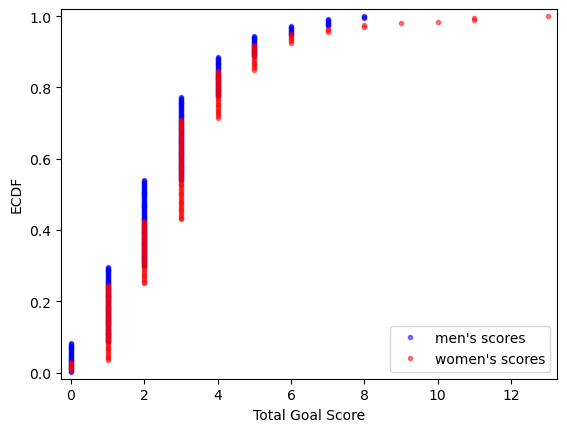

In [48]:
# Initial Graphical Exploratory Analysis

# Import data
df_m = pd.read_csv('men_results.csv')
df_w = pd.read_csv('women_results.csv')

# Parse date column 
df_m['date'] = pd.to_datetime(df_m['date']).dt.strftime('%Y-%m-%d')
df_w['date'] = pd.to_datetime(df_w['date']).dt.strftime('%Y-%m-%d')

# Slice data as per conditions
df_m = df_m[(df_m['tournament'] == "FIFA World Cup") & (df_m['date'] >= "2002-01-01")]
df_w = df_w[(df_w['tournament'] == "FIFA World Cup") & (df_w['date'] >= "2002-01-01")]

# Summarize
df_m['total_score'] = np.sum([df_m['home_score'], df_m['away_score']], axis=0)
df_w['total_score'] = np.sum([df_w['home_score'], df_w['away_score']], axis=0)


df_m_mean = np.mean(df_m['total_score'])
df_w_mean = np.mean(df_w['total_score'])


# Compute difference of means (Observed Test Statistic)
diff_of_means_observed = df_w_mean - df_m_mean


# Reshape
df_m = df_m.drop(['home_score', 'away_score'], axis=1)
df_w = df_w.drop(['home_score', 'away_score'], axis=1)

# Make x and y arrays to plot ecdf
x_m = np.sort(df_m['total_score'])
n_m = len(x_m)
y_m = np.arange(1, n_m+1)/n_m

x_w = np.sort(df_w['total_score'])
n_w = len(x_w)
y_w = np.arange(1, n_w+1)/n_w

# # Plot ECDF
_ = plt.plot(x_m, y_m, marker='.', linestyle='none', color='blue', alpha=0.5)
_ = plt.plot(x_w, y_w, marker='.', linestyle='none', color='red', alpha=0.5)
_ = plt.xlabel('Total Goal Score')
_ = plt.ylabel('ECDF')
_ = plt.legend(('men\'s scores', 'women\'s scores'), loc='lower right')
plt.margins(0.02)
plt.show()

In [47]:
# Computing p-value with Permutation Test

# Compute the mean
df_m_mean = np.mean(df_m['total_score'])
df_w_mean = np.mean(df_w['total_score'])

# print(df_m_clean_mean)
# print(df_w_clean_mean)

# # Compute difference of means (Observed Test Statistic)
diff_of_means_observed = df_w_mean - df_m_mean

# Generate replicates
perm_replicates = dcst.draw_perm_reps(df_w['total_score'], df_m['total_score'], dcst.diff_of_means, 10000)

# Compute p-value
p = np.sum(perm_replicates >= diff_of_means_observed)/10000

# Print p-value
print('p-value: ', p)

p-value:  0.0016


In [45]:
# Running a bootstrap hypothesis test in order to compute the p-value and 95% Confidence Interval

# Compute combined mean to normalise datasets
combined_mean = (df_m_mean + df_w_mean) / 2

# new arrays to perform bootstrap on
men_shifted = (df_m['total_score'] - df_m_mean) + combined_mean
women_shifted = (df_w['total_score'] - df_w_mean) + combined_mean

# Acquire 10000 replicates of means
replicates_m = dcst.draw_bs_reps(men_shifted, np.mean, size=10000)
replicates_w = dcst.draw_bs_reps(women_shifted, np.mean, size=10000)

# Compute difference of means for replicates (Sample Test Statistic)
diff_of_means_reps = replicates_w - replicates_m

# Compute p-value
p = np.sum(diff_of_means_reps >= diff_of_means_observed)/len(diff_of_means_reps)

print('p-value: ', p)

# Compute 95% Confidence Interval
conf_int = np.percentile(diff_of_means_reps, [2.5, 97.5])
conclusion = "Conclusion: Assuming a significance level of 10% (0.1): \n Since the p-value is not less than 0.1, we fail to reject the null hypothesis\n and can conclude that there is not enough evidence to support the alternative hypothesis."
print('Difference of means: ', diff_of_means_observed,'\n' '95% Confidence Interval: ', conf_int, '\n', conclusion)


p-value:  0.0039
Difference of means:  0.4669791666666665 
95% Confidence Interval:  [-0.32375521  0.33635937] 
 Conclusion: Assuming a significance level of 10% (0.1): 
 Since the p-value is not less than 0.1, we fail to reject the null hypothesis
 and can conclude that there is not enough evidence to support the alternative hypothesis.


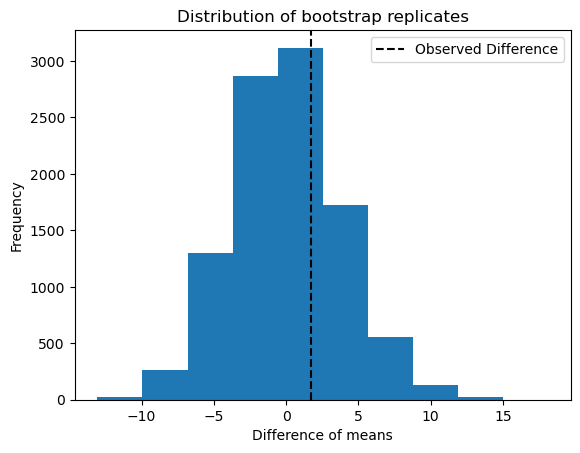

In [33]:
# Histogram of difference of mean (replicates vs observed)
_ = plt.hist(diff_of_means_reps)
# Add a vertical line for the observed difference of means
plt.axvline(diff_of_means_observed, color='black', linestyle='--', label='Observed Difference')
plt.xlabel('Difference of means')
plt.ylabel('Frequency')
plt.title('Distribution of bootstrap replicates')
plt.legend()
plt.show()

C:\Users\0zn1z\AppData\Local\Temp\ipykernel_9700\1819178104.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men_subset["group"] = "men"
C:\Users\0zn1z\AppData\Local\Temp\ipykernel_9700\1819178104.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women_subset["group"] = "women"
C:\Users\0zn1z\AppData\Local\Temp\ipykernel_9700\1819178104.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

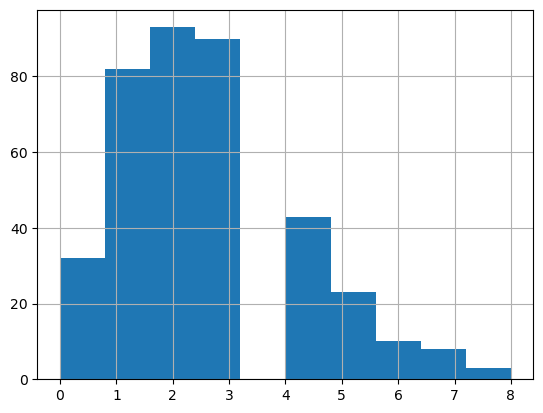

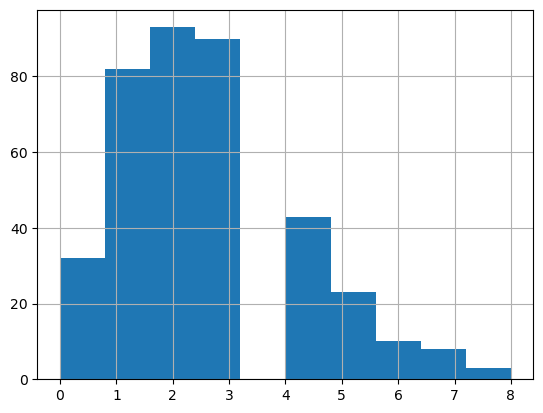

IndexError: invalid index to scalar variable.

<Figure size 640x480 with 0 Axes>

In [6]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
#import pingouin
from scipy.stats import mannwhitneyu

# Load men's and women's datasets
men = pd.read_csv("men_results.csv")
women = pd.read_csv("women_results.csv")

# Filter the data for the time range and tournament
men["date"] = pd.to_datetime(men["date"])
men_subset = men[(men["date"] > "2002-01-01") & (men["tournament"].isin(["FIFA World Cup"]))]
women["date"] = pd.to_datetime(women["date"])
women_subset = women[(women["date"] > "2002-01-01") & (women["tournament"].isin(["FIFA World Cup"]))]

# Create group and goals_scored columns
men_subset["group"] = "men"
women_subset["group"] = "women"
men_subset["goals_scored"] = men_subset["home_score"] + men_subset["away_score"]
women_subset["goals_scored"] = women_subset["home_score"] + women_subset["away_score"]

# Determine normality using histograms
men_subset["goals_scored"].hist()
plt.show()
plt.clf()

# Goals scored is not normally distributed, so use Wilcoxon-Mann-Whitney test of two groups
men_subset["goals_scored"].hist()
plt.show()
plt.clf()

# Combine women's and men's data and calculate goals scored in each match
both = pd.concat([women_subset, men_subset], axis=0, ignore_index=True)

# Transform the data for the pingouin Mann-Whitney U t-test/Wilcoxon-Mann-Whitney test
both_subset = both[["goals_scored", "group"]]
both_subset_wide = both_subset.pivot(columns="group", values="goals_scored")

# # Perform right-tailed Wilcoxon-Mann-Whitney test with pingouin
# results_pg = pingouin.mwu(x=both_subset_wide["women"],
#                           y=both_subset_wide["men"],
#                           alternative="greater")

# Alternative SciPy solution: Perform right-tailed Wilcoxon-Mann-Whitney test with scipy
results_scipy = mannwhitneyu(x=women_subset["goals_scored"],
                             y=men_subset["goals_scored"],
                             alternative="greater")

# Extract p-value as a float
#p_val = results_scipy["p-val"].values[0]
p_val = results_scipy[0]["p-val"]
# Determine hypothesis test result using sig. level
if p_val <= 0.01:
    result = "reject"
else:
    result = "fail to reject"

result_dict = {"p_val": p_val, "result": result}